In [16]:
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt



# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
from Funcs import *
from Model import *
model = career_choice()
model.setup()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Question 1
We consider a graduate $i$ making a choice between entering $J$ different career tracks.  
We start by calculating the expected utility and the average realised utility for each career choice.  

We do this by first drawing 10.000 epsilons for each of the 3 careers and storing them, such that we have $u^1_{i,j}=[\varepsilon_1, \varepsilon_2, \varepsilon_3]$ (with hopefully obvious notation).  
We then use these epsilons to calculate what is printed below as "Realised utilities", which is simply the epsilon multiplied by the v-array.  

We then calculate the mean of these 10.000 draws of epsilon, by taking the mean across each column that that the mean for career 1, 2 and 3 are calculated seperately. This is printed below as "Mean of all 10.000 realised utilities".  

Finally we calculate the expected utility by taking the mean across all the epsilons (remembering that we stored them) and thus simply calculating it directly. This gives the same value as above and is printed as "Expected utility"

In [17]:
realised_utility, expected_utility, realised_utility_mean = sim_utility(model.par)
print("Realised utilities")
print(realised_utility)
print(50*'-')
print("Mean of all 10.000 realised utilities")
print(realised_utility_mean)
print(50*'-')
print("Expected utility")
print(expected_utility)

Realised utilities
[[ 1.99342831e+00  1.72347140e+00  4.29537708e+00]
 [ 4.04605971e+00  1.53169325e+00  2.53172609e+00]
 [ 4.15842563e+00  3.53486946e+00  2.06105123e+00]
 ...
 [ 4.64977830e+00  3.75341367e+00  5.35983092e-01]
 [-1.52241651e+00  8.45424299e-01  5.88920797e+00]
 [-2.73463113e-03 -1.78471365e+00  2.54223158e+00]]
--------------------------------------------------
Mean of all 10.000 realised utilities
[0.98858639 2.00533542 3.00394879]
--------------------------------------------------
Expected utility
[0.98858639 2.00533542 3.00394879]


# Question 2
The indivuals now consider their friends when making career choices.  
We are told that they have a number of friends equal to their index, such that person 1 has 1 friend, person 2 has 2 etc.  
Their prior expectations are given by:
$$\tilde{u}^k_{i,j}(F_i)=\frac{1}{F_i}\sum_{f=1}^{F_i}\left(v_j+\varepsilon_{f,j}^k\right)$$
Here, we are a bit unsure about the notation, but we will assume the following (where we use 1 draw as an example):
Person 1 draws 3 values (one for each career) such that $$\varepsilon_{1,j}=[\varepsilon_{11},\varepsilon_{12},\varepsilon_{13}]$$
Person 2 draws 6 values (two for each career) such that $$\varepsilon_{2,j}=\left[\begin{array}{ccc}
   \varepsilon_{11}  & \varepsilon_{12} & \varepsilon_{13} \\
    \varepsilon_{21}  & \varepsilon_{22} & \varepsilon_{23}
\end{array}\right]$$
Etc. for all other persons, such that person 3 draws 9 values. They then sum column-wise such that all person end up with a $1\times3$ matrix of epsilons. That is how we interpret the sum from the prior expectations equation.  
We can then find the career track with the highest expected utility for each draw.


Again, the notation is hopefully obvious...

[[0.1515 0.2945 0.554 ]
 [0.1975 0.3138 0.4887]
 [0.2194 0.3267 0.4539]
 [0.2325 0.3172 0.4503]
 [0.2418 0.3232 0.435 ]
 [0.2521 0.327  0.4209]
 [0.2614 0.3304 0.4082]
 [0.262  0.321  0.417 ]
 [0.2565 0.3304 0.4131]
 [0.2711 0.3307 0.3982]]


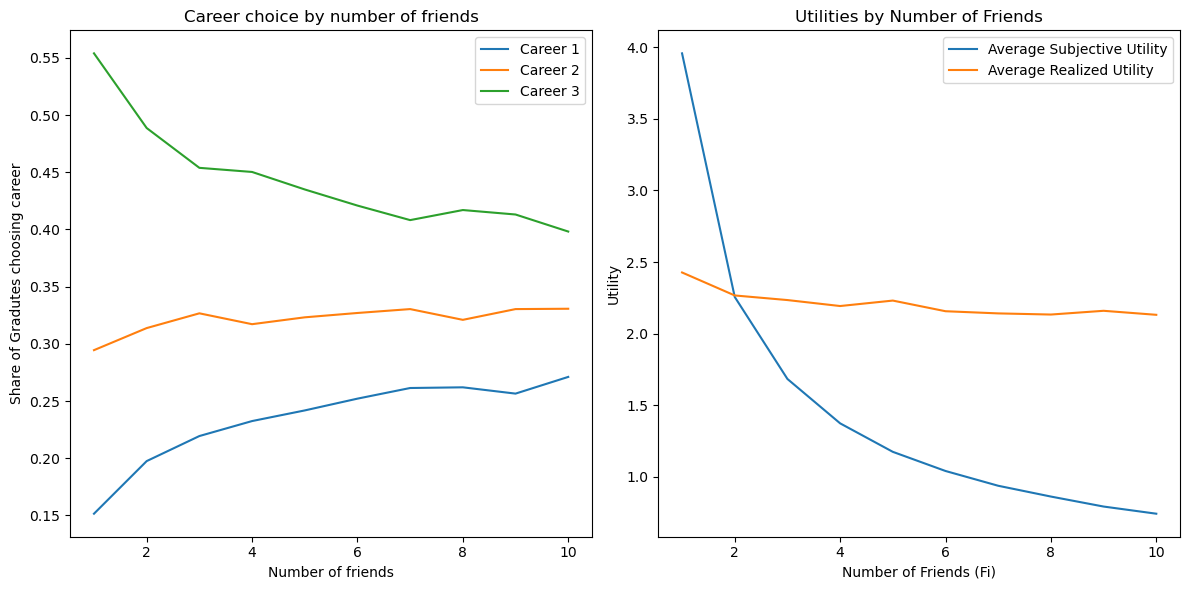

In [35]:
def friend_utility(par):

    np.random.seed(42)

    # Arrays to store results)
    friend_epsilon_storage = np.zeros((par.N, par.K, par.J))
    actual_epsilon_storage = np.zeros((par.N, par.K, par.J))
    expected_utility = np.zeros((par.N, par.K, par.J))
    career_choice = np.zeros((par.N, par.K), dtype=int)
    actual_utility = np.zeros((par.N, par.K, par.J))

    for i in range(par.N):    # Loop over individuals
        
        # We are told that individual i has i friends. We add 1 to account for Python indexing
        Fi = i + 1

        for k in range(par.K):    # Loop over simulations
            for j in range(par.J):  # Loop over careers
                
                # Draw epsilon for each friend and sum column-wise
                draws = np.random.normal(0, par.sigma, (Fi, par.J))
                epsilon_friend = np.sum(draws, axis=0)  
                # Add epsilon to storage
                friend_epsilon_storage[i, k, :] = epsilon_friend
                # We now have that for person 1, there is only one epsilon in each column, while for person 2 it is the sum of 2 epsilons etc.

                # Draw actual epsilons
                epsilon_actual = np.random.normal(0, par.sigma, par.J)
                # Add epsilon to storage
                actual_epsilon_storage[i, k, :] = epsilon_actual

                # Calculate expected utility
                utility_temp = (par.v+epsilon_friend)/Fi
                # Add expected utility to storage
                expected_utility[i, k, :] = utility_temp

                # Find career choice that maximizes expected utility
                career_choice[i, k] = np.argmax(utility_temp)

                # Calculate actual utility
                actual_utility[i, k, :] = par.v + epsilon_actual


    return friend_epsilon_storage, actual_epsilon_storage, expected_utility, career_choice, actual_utility

friend_epsilon_storage, actual_epsilon_storage, expected_utility, career_choice, actual_utility = friend_utility(model.par)
# # print epsilon storage for person 2:
# print("Epsilon storage for person 2")
# print(friend_epsilon_storage[1,:,:])
# print(actual_epsilon_storage[:,1,:])
# print(expected_utility[1,:,:])
# print(career_choice[1,:])
# print(actual_utility[1,:,:])


def analyze(par, best_career, expected_utility, actual_utility):
    # Initialize arrays to store results for each type of graduate (i)
    career_shares = np.zeros((par.N, par.J))
    expected_average_utility = np.zeros(par.N)
    actual_average_utility = np.zeros(par.N)

    for i in range(par.N):  # Loop over types of graduates
        # Calculate the shares of graduates choosing each career for this type of graduate
        career_counts = np.zeros(par.J)
        for j in range(par.J):
            career_counts[j] = np.sum(best_career[i, :] == j)
        career_shares[i, :] = career_counts / par.K

        # Calculate the expected average utility from choosing the best career for this type of graduate
        expected_utility_sum = 0
        actual_utility_sum = 0
        for k in range(par.K):
            expected_utility_sum += expected_utility[i, k, best_career[i, k]]
            actual_utility_sum += actual_utility[i, k, best_career[i, k]]
        expected_average_utility[i] = expected_utility_sum / par.K
        actual_average_utility[i] = actual_utility_sum / par.K

    return career_shares, expected_average_utility, actual_average_utility

career_shares, expected_average_utility, actual_average_utility = analyze(model.par, career_choice, expected_utility, actual_utility)

print(career_shares)

def plotting(career_shares, expected_average_utility, actual_average_utility):
    x = np.arange(1, model.par.N+1)

    plt.figure(figsize=(12, 6))

    # plot career choices
    plt.subplot(1,2,1)
    for j in range(model.par.J):
        plt.plot(x, career_shares[:,j], label=f'Career {j+1}')
    plt.xlabel('Number of friends')
    plt.ylabel('Share of Gradutes choosing career')
    plt.title('Career choice by number of friends')
    plt.legend()

    # Plot utilities
    plt.subplot(1, 2, 2)
    plt.plot(x, expected_average_utility, label='Average Subjective Utility')
    plt.plot(x, actual_average_utility, label='Average Realized Utility')
    plt.xlabel('Number of Friends (Fi)')
    plt.ylabel('Utility')
    plt.title('Utilities by Number of Friends')
    plt.legend()
    
    plt.tight_layout()
    plt.show()



# Plot results
plotting(career_shares, expected_average_utility, actual_average_utility)

In [21]:
def friend_utility(par):
    '''Simulate utility for friends'''
    np.random.seed(42)

    # Arrays to store utilities
    friend_expected_utility = np.zeros((par.K, par.N, par.J))
    own_realised_utility = np.zeros((par.K, par.N, par.J))
    own_expected_utility = np.zeros((par.K, par.N, par.J))
    chosen_career = np.zeros((par.K, par.N,), dtype=int)
    
    for i in range(par.N):  # Loop over friends
        
        # We are told they have i friends. We add 1 to accound for Python indexing
        Fi = i + 1

        for k in range(par.K):          # Loop over simulations        
    
            for j in range(par.J):      # Loop over careers
                
                # Friend
                friend_epsilon = np.random.normal(0, par.sigma, Fi)
                friend_expected_utility[k,i,j] = 1/Fi * np.sum(par.v[j] + friend_epsilon)

                # Self
                own_epsilon = np.random.normal(0, par.sigma)
                own_realised_utility[k,i,j] = par.v[j] + own_epsilon
                own_expected_utility[k,i,j] = friend_expected_utility[k,i,j]
            
            # Find the career with the highest expected utility
            chosen_career[k,i] = np.argmax(own_expected_utility[k,i, :])

    return friend_expected_utility , own_realised_utility, own_expected_utility, chosen_career

friend_expected_utility , own_realised_utility, own_expected_utility, chosen_career = friend_utility(model.par)
print(chosen_career)

[[1 2 2 ... 2 2 2]
 [0 1 2 ... 2 2 2]
 [0 1 1 ... 2 2 2]
 ...
 [1 1 2 ... 1 2 2]
 [1 2 2 ... 2 2 2]
 [0 2 2 ... 2 1 2]]


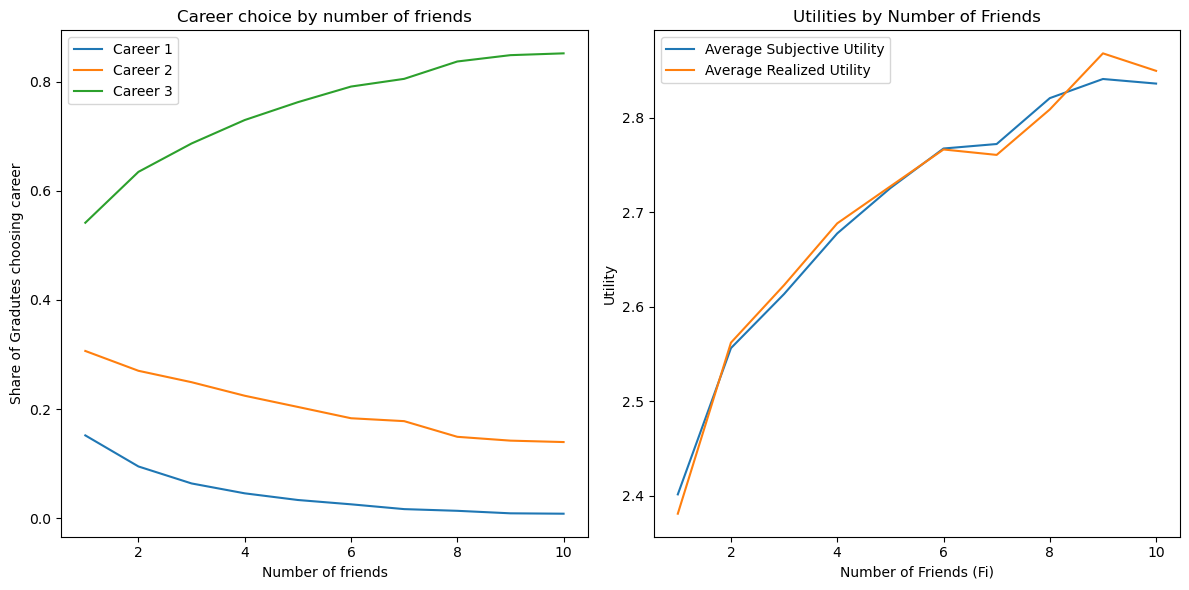

In [22]:
def analyze(par, chosen_career, own_expected_utility, own_realised_utility):
    career_counts = np.zeros((par.N, par.J))
    average_expected_utility = np.zeros(par.N)
    average_realised_utility = np.zeros(par.N)

    for i in range(par.N):
        for j in range(par.J):
            career_counts[i,j] = np.mean(chosen_career[:,i] == j)
        
        expected_utility_temp = own_expected_utility[:,i, chosen_career[:,i]]
        realised_utility_temp = own_realised_utility[:,i, chosen_career[:,i]]

        average_expected_utility[i] = np.mean(expected_utility_temp)
        average_realised_utility[i] = np.mean(realised_utility_temp)
    
    return career_counts, average_expected_utility, average_realised_utility



def plotting(career_counts, average_expected_utility, average_realised_utility):
    x = np.arange(1, model.par.N+1)

    plt.figure(figsize=(12, 6))

    # plot career choices
    plt.subplot(1,2,1)
    for j in range(model.par.J):
        plt.plot(x, career_counts[:,j], label=f'Career {j+1}')
    plt.xlabel('Number of friends')
    plt.ylabel('Share of Gradutes choosing career')
    plt.title('Career choice by number of friends')
    plt.legend()

    # Plot utilities
    plt.subplot(1, 2, 2)
    plt.plot(x, average_expected_utility, label='Average Subjective Utility')
    plt.plot(x, average_realised_utility, label='Average Realized Utility')
    plt.xlabel('Number of Friends (Fi)')
    plt.ylabel('Utility')
    plt.title('Utilities by Number of Friends')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Calculate the aksed for sizes
career_counts, avg_subjective_utility, avg_realized_utility = analyze(model.par, chosen_career, own_expected_utility, own_realised_utility)

# Plot results
plotting(career_counts, avg_subjective_utility, avg_realized_utility)

